In [64]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import *
from keras.models import Model, load_model, Sequential
import cv2
from tqdm import tqdm
import keras
    
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 15, 4
plt.style.use('ggplot')


### Load metadata

In [66]:
# Open all 
lane1 = pd.read_csv('Dataset/2016-01-30--11-24-51/Metadata/lane_df.csv',index_col=0)

lane4 = pd.read_csv('Dataset/2016-02-02--10-16-58/Metadata/lane_df.csv',index_col=0)

lane5 = pd.read_csv('Dataset/2016-02-08--14-56-28/Metadata/lane_df.csv',index_col=0)

lane6 = pd.read_csv('Dataset/2016-02-11--21-32-47/Metadata/lane_df.csv',index_col=0)

lane7 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

In [67]:
X = []
Y = []
for df in [lane1, lane5, lane6, lane7]:#, lane8, lane9, lane10]:
    X.append(df['filenames'].values)
    Y.append(df['steering_angle'].values)

X = np.concatenate(X)
Y = np.concatenate(Y).astype('float32')

# Subsample at 2.5 Hz
X = X[::2]
Y = Y[::2]

print('Shape X', np.shape(X))
print('Shape Y', np.shape(Y))

Shape X (93054,)
Shape Y (93054,)


### Define functions

In [4]:
def get_optical_flow(frame1, frame2):
    '''Frame1: previous frame
       Frame2: last frame
       Returns: Polar optical flow in RBG'''
    
    prev = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    # Get present frame
    next_ = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prev, next_, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    hsv[...,0] = ang*180/np.pi/2

    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)

    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)


def process_line(filename):
    '''Process one line of the batch directory.------------------------
     Read a list of two filenames: previous - current.
     Returns the optical flow !!
    '''
    frame1 = np.array(cv2.imread(filename[0])) # previous
    frame2 = np.array(cv2.imread(filename[1])) # present
    flow = get_optical_flow(frame1, frame2) # flow present vs previous 
    
    return frame2, flow  


def get_index(X, Y, offset=4):
    new_X = []
    new_Y = []
    for i in range(int(X.shape[0]-offset)):
        pair_X = [X[i], X[i + offset]]
        new_X.append(pair_X)
        new_Y.append(Y[i + offset])
        
    return np.array(new_X), np.array(new_Y)


def rmse(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1))

### Generate data indexes

In [5]:
new_X, new_Y = get_index(X, Y, offset=1)

### Suffle indexes - Only 2% of the data to compute the TSNE

In [6]:
# Normalize target
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(new_Y.reshape(-1,1))
new_y = scaler.transform(new_Y.reshape(-1,1)) #y minuscule est normalisé


# Suffle examples
import random
proportion = 0.02
# Generate a random selection of indexes
indexes = random.sample(range(0, new_X.shape[0]), int(new_X.shape[0]*proportion))

# Select desired examples
shuffle_X = new_X[indexes]
shuffle_Y = new_y[indexes].astype('float32') # Already normalized

### Load images and compute Flows

In [18]:
flows = []
images = []

for element in tqdm(shuffle_X):
    # Get current frame and optical flow
    current, flow = process_line(element)
    flows.append(flow)
    images.append(current)

flows = np.array(flows)   #Flows
images = np.array(images)
flows = flows.reshape(-1,160,320,3)
images = images.reshape(-1,160,320,3)


100%|██████████| 1861/1861 [00:33<00:00, 55.72it/s]


### Load pre-trained models 

In [19]:
# Load spatial Network
spatial = load_model('checkpoint_nvidia_model.hdf5', custom_objects={'rmse': rmse})

# Load flow Network
flow = load_model('flownnorm_check_temp_50_all.hdf5', custom_objects={'rmse': rmse})

### Pop final layers and get the Embeddings

In [20]:
for i in range(4):
    spatial.pop()
    
for i in range(4):
    flow.pop()

In [21]:
spatial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 78, 158, 24)       1824      
_________________________________________________________________
batch_normalization_6 (Batch (None, 78, 158, 24)       96        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 37, 77, 36)        21636     
_________________________________________________________________
batch_normalization_7 (Batch (None, 37, 77, 36)        144       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 37, 48)        43248     
_________________________________________________________________
batch_normalization_8 (Batch (None, 17, 37, 48)        192       
__________

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [22]:
flow.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 33, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 33, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27456)             0         
Total para

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


### Compute embeddings with sample data

In [23]:
spatial_emb = spatial.predict(images)
temporal_emb = flow.predict(flows)

In [24]:
from sklearn.manifold import TSNE

def get_TSNE(X):
    return TSNE(n_components=2).fit_transform(X)

In [25]:
spatial_tsne = get_TSNE(spatial_emb)
temporal_tsne = get_TSNE(temporal_emb)

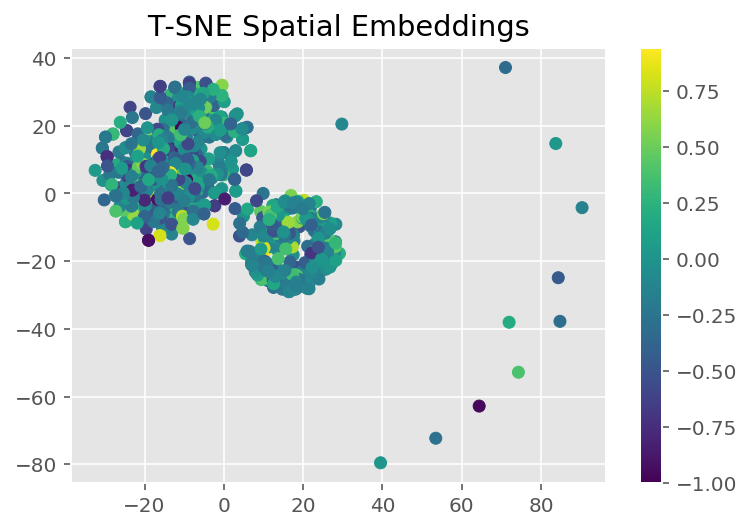

In [43]:
plt.scatter(spatial_tsne[:,0][:1000], 
            spatial_tsne[:,1][:1000], 
            c=shuffle_Y.reshape(-1)[:1000])
plt.title('T-SNE Spatial Embeddings')
plt.colorbar()

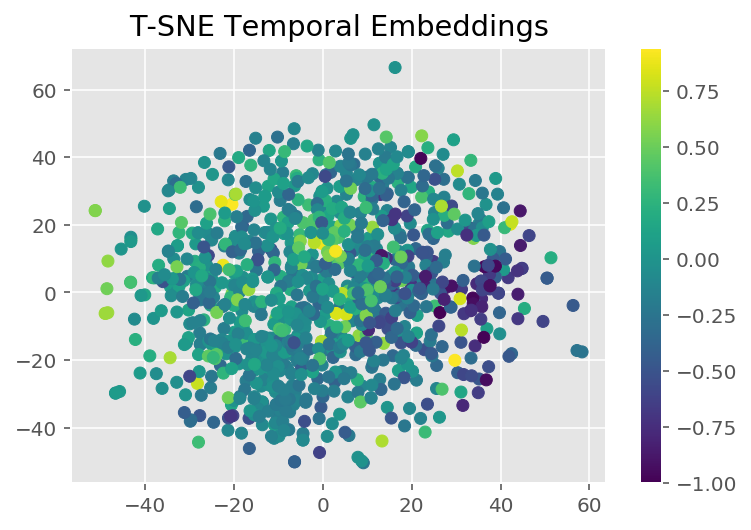

In [44]:
plt.scatter(temporal_tsne[:,0][:1000],
            temporal_tsne[:,1][:1000],
            c=shuffle_Y.reshape(-1)[:1000])
plt.title('T-SNE Temporal Embeddings')
plt.colorbar()

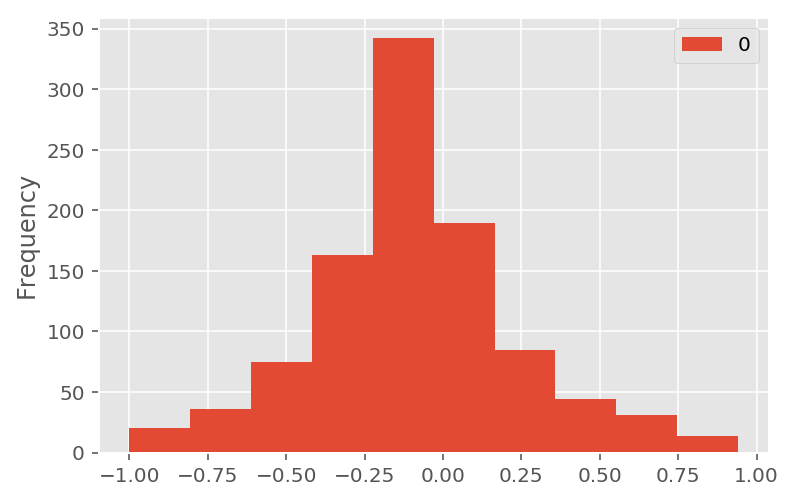

In [40]:
pd.DataFrame(shuffle_Y[:1000]).plot.hist()

Text(0.5,1,'Distribution Temporal T-SNE dim 0')

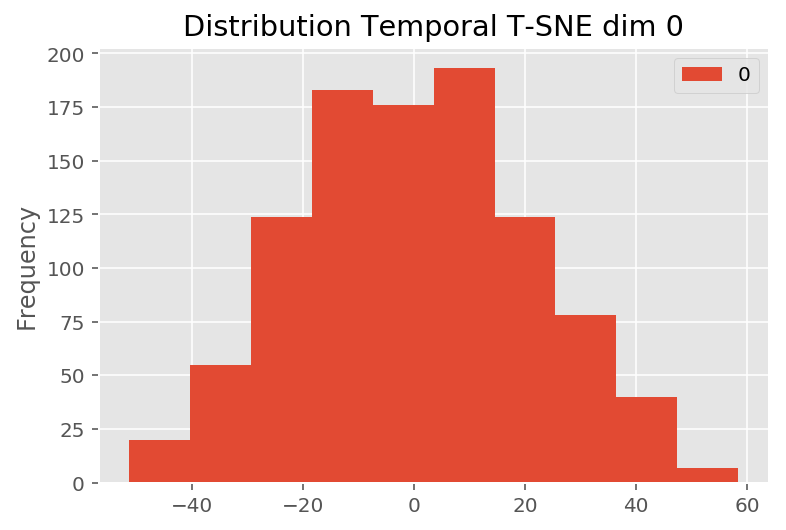

In [48]:
pd.DataFrame(temporal_tsne[:,0][:1000]).plot.hist()
plt.title('Distribution Temporal T-SNE dim 0')

Text(0.5,1,'Distribution Temporal T-SNE dim 1')

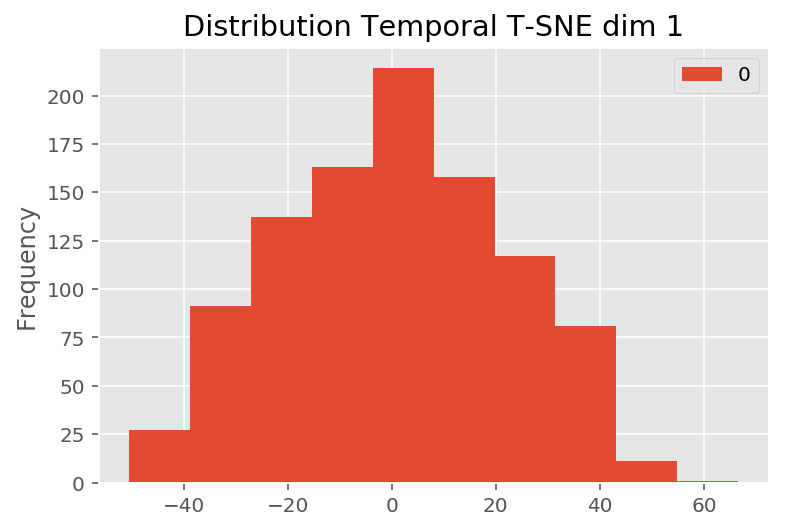

In [49]:
pd.DataFrame(temporal_tsne[:,1][:1000]).plot.hist()
plt.title('Distribution Temporal T-SNE dim 1')

Text(0.5,1,'Distribution Spatial T-SNE dim 0')

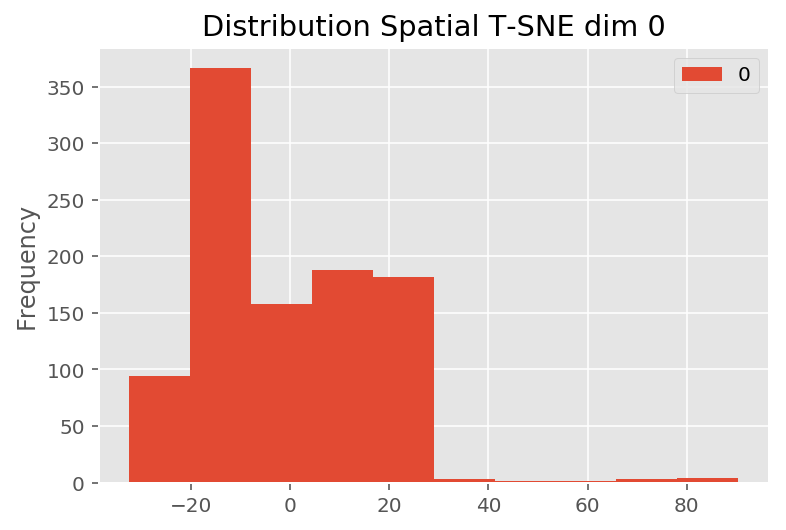

In [51]:
pd.DataFrame(spatial_tsne[:,0][:1000]).plot.hist()
plt.title('Distribution Spatial T-SNE dim 0')

Text(0.5,1,'Distribution Spatial T-SNE dim 0')

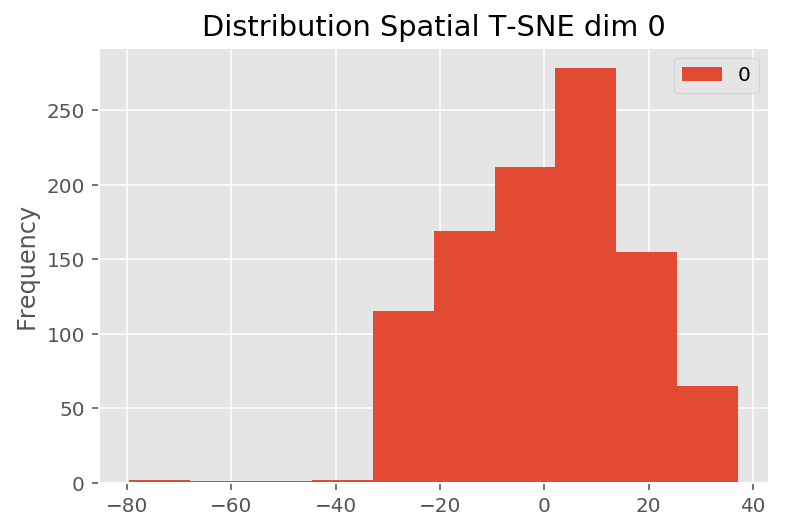

In [52]:
pd.DataFrame(spatial_tsne[:,1][:1000]).plot.hist()
plt.title('Distribution Spatial T-SNE dim 0')

## Conclusions
   - The distribution of the angles is almost normal.
   - The temporal manifold is much more compact. Angles are mapped from the right part (left turns), the center (right turns) and left part of the manifold (straights). There is not apparent separation between groups, this soft behaviour is espected as we did not use a categorical optimization function, but a regression.
   - The distribution of the temporal manifold is also normal with less kurtosis. Significa, menos apuntalamiento. Meaning part of the examples of angles close to 0 where maped across different regions, both left and right of the map.
   
   - The spatial embeddings are very different. It would mean that the network is actually learning different features. Whe observe three main groups: a first one at the left of the manifold by left turns. Another a the center with straight turns and a crown of points at the right, apparently non-related to its class. It could mean these examples are atypical.
   
    

## T-SNE of input images

In [60]:
# Convert to Gray and Flatten() :)
gray_imgs = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in images]
gray_imgs = [x.flatten() for x in gray_imgs]

In [62]:
gray_imgs = np.array(gray_imgs)

In [ ]:
input_images_tsne = get_TSNE(gray_imgs[:1000])

In [ ]:
plt.scatter(input_images_tsne[:,0][:1000], 
            input_images_tsne[:,1][:1000], 
            c=shuffle_Y.reshape(-1)[:1000])
plt.title('T-SNE Input images')
plt.colorbar()

In [ ]:
input_flows_tsne = get_TSNE(flows)

In [ ]:
plt.scatter(input_flows_tsne[:,0][:1000], 
            input_flows_tsne[:,1][:1000], 
            c=shuffle_Y.reshape(-1)[:1000])
plt.title('T-SNE Input images')
plt.colorbar()